In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

In [89]:
import sklearn

In [91]:
xgb.__version__, sklearn.__version__

('0.90', '0.22.1')

In [7]:
from sklearn.ensemble import RandomForestRegressor
## visualize one of the tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


In [25]:
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [8]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, LassoCV)

In [9]:
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

ModuleNotFoundError: No module named 'mlxtend'

In [10]:
## hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
tuning = {
    'max_depth': [7,10,13,15,17],
    'max_features': [5,7,10,15,20,30],
    'min_samples_split': [2,5,7,10],
    'n_estimators': [10,30,50,70]
}

In [11]:
import Utils
importlib.reload(Utils) ## update the Utils library

<module 'Utils' from 'C:\\Users\\CSY\\Desktop\\potato-lankau\\scripts\\Utils.py'>

In [12]:
import ML_model as ml
importlib.reload(ml)

<module 'ML_model' from 'C:\\Users\\CSY\\Desktop\\potato-lankau\\scripts\\ML_model.py'>

In [13]:
meta = pd.read_csv("..//data//potatometadata_forClaudia.csv")
taxa = pd.read_csv("..//data//potatorar_forsubmission.csv")
taxa.columns.values[0] = "FieldID"
taxa = taxa.rename(columns = {'FieldID':'FieldID'})

# Data Visualization on Original Data

In [14]:
meta_explore = meta[meta["Experiment"] == 2015]
meta_confirm = meta[meta["Experiment"] == 2017]

In [12]:
def scatter_disease(ax, df, title):
    ax.scatter(df.FieldID, df.diffCSscore)
    ax.set_xlabel('FieldId', fontsize=15)
    ax.set_xticks(df.FieldID)
    ax.set_ylabel('Disease Severity', fontsize=15)
    ax.set_title(title, size=20)

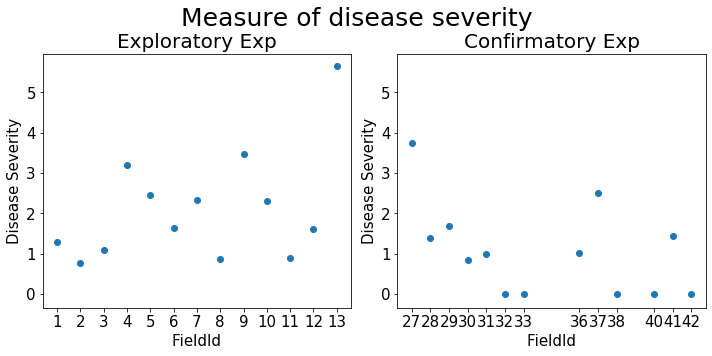

In [13]:
fig2 = plt.figure(figsize=(10, 5))
fig2.suptitle("Measure of disease severity", fontsize=25)
ax21 = fig2.add_subplot(1,2,1)
scatter_disease(ax21, meta_explore, "Exploratory Exp")
ax22 = fig2.add_subplot(1,2,2,sharey=ax21)
scatter_disease(ax22, meta_confirm, "Confirmatory Exp")
fig2.tight_layout()
fig2.subplots_adjust(top=0.85)
plt.show()

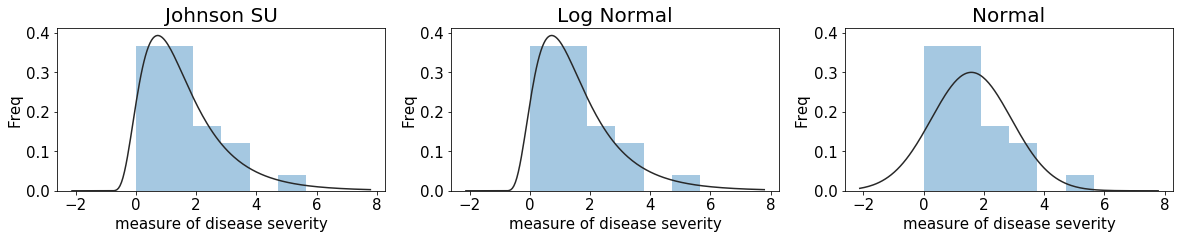

In [14]:
Utils.check_dist(meta.diffCSscore, xlab="measure of disease severity")

The distribution of disease score is more like Johnson SU or Log Normal rather than Normal distribution. Need some transformation.

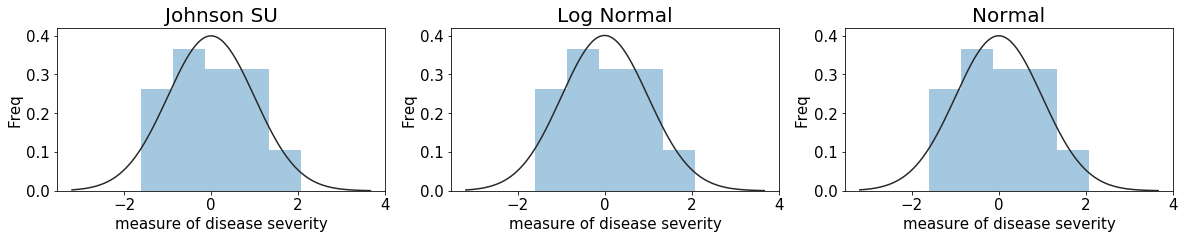

{-7.73291132432589,
 -0.9431298912958859,
 0.07409141934956123,
 1.8920552756904958}

In [15]:
yt_disease, gamma, eta, epsilon, lbda = Utils.johnson_transform(meta.diffCSscore)
Utils.check_dist(yt_disease, xlab="measure of disease severity")
trans_param = {gamma, eta, epsilon, lbda}
trans_param

## meta data, taxa data, and these two data set combined preprocessing

In [16]:
# drop non-numeric column
meta_clean = meta.drop(['field name', 'diffCSscore'], axis=1)
# In the new field, experiment conducted in 2015 is labeled as 0 whereas in 2017 as 1
meta_clean['Experiment'] = meta_clean['Experiment'].replace(2015, 0)
meta_clean['Experiment'] = meta_clean['Experiment'].replace(2017, 1)
# drop all column related to yield
yld_list = ['Mean.Control.Microbe', 'Mean.LowN.Microbe', 'varCtub', 'varNtub', 'invVar_Ctub',
           'invVar_Ntub', 'Std.Err.Mean.Control.Microbe', 'Std.Err.Mean.LowN.Microbe', ]
disease_unwanted = ['varCSscore', 'invVar_Csscore', 'seCSscore']
meta_clean = meta_clean.drop(yld_list, axis=1)
meta_clean = meta_clean.drop(disease_unwanted, axis=1)
meta_clean_2 = meta_clean.set_index('FieldID')
meta_clean_2_unnormalized = meta_clean_2.copy()

In [17]:
# Pay attention here. yt has the index of field id, whereas yt_disease is just a series of number starting at 0
yt = yt_disease.copy()
yt.index = meta_clean_2.index  
yt

FieldID
1     0.015142
2    -0.486763
3    -0.154928
4     1.195968
5     0.814400
6     0.303205
7     0.744778
8    -0.369501
9     1.312314
10    0.732274
11   -0.339759
12    0.279803
13    2.075431
27    1.424344
28    0.093800
29    0.326124
30   -0.409760
31   -0.252561
32   -1.605319
33   -1.605319
36   -0.230164
37    0.842071
38   -1.605319
40   -1.605319
41    0.142125
42   -1.605319
Name: diffCSscore, dtype: float64

In [18]:
taxa_clean = taxa.loc[:, (taxa != 0).any(axis=0)]  # drop columns contain only 0
taxa_clean_2 = taxa_clean.set_index('FieldID')
taxa_clean_2_unnormalized = taxa_clean_2.copy()

In [19]:
clean = pd.concat([meta_clean_2_unnormalized.drop(['Experiment'], axis=1), taxa_clean_2_unnormalized], axis=1)
total, mu_total, sd_total = Utils.normalization(clean)
total = pd.concat([meta_clean_2_unnormalized.Experiment, total], axis=1)

xtrain_d, xval_d, ytrain_d, yval_d = train_test_split(total, yt, test_size=0.2, random_state=1)

In [20]:
xtrain_meta_d = xtrain_d[meta_clean_2.columns]
xval_meta_d = xval_d[meta_clean_2.columns]
xtrain_taxa_d = pd.concat([xtrain_meta_d.Experiment, xtrain_d[taxa_clean_2.columns]], axis=1)
xval_taxa_d = pd.concat([xval_meta_d.Experiment, xval_d[taxa_clean_2.columns]], axis=1)

In [ ]:
meta_and_yt = pd.concat([meta_clean_2, yt], axis=1)

meta_and_yt.columns.values[-1] = "transformed disease score"
# meta_and_yt = taxa.rename(columns = {'FieldID':'FieldID'})
meta_and_yt.head(2)

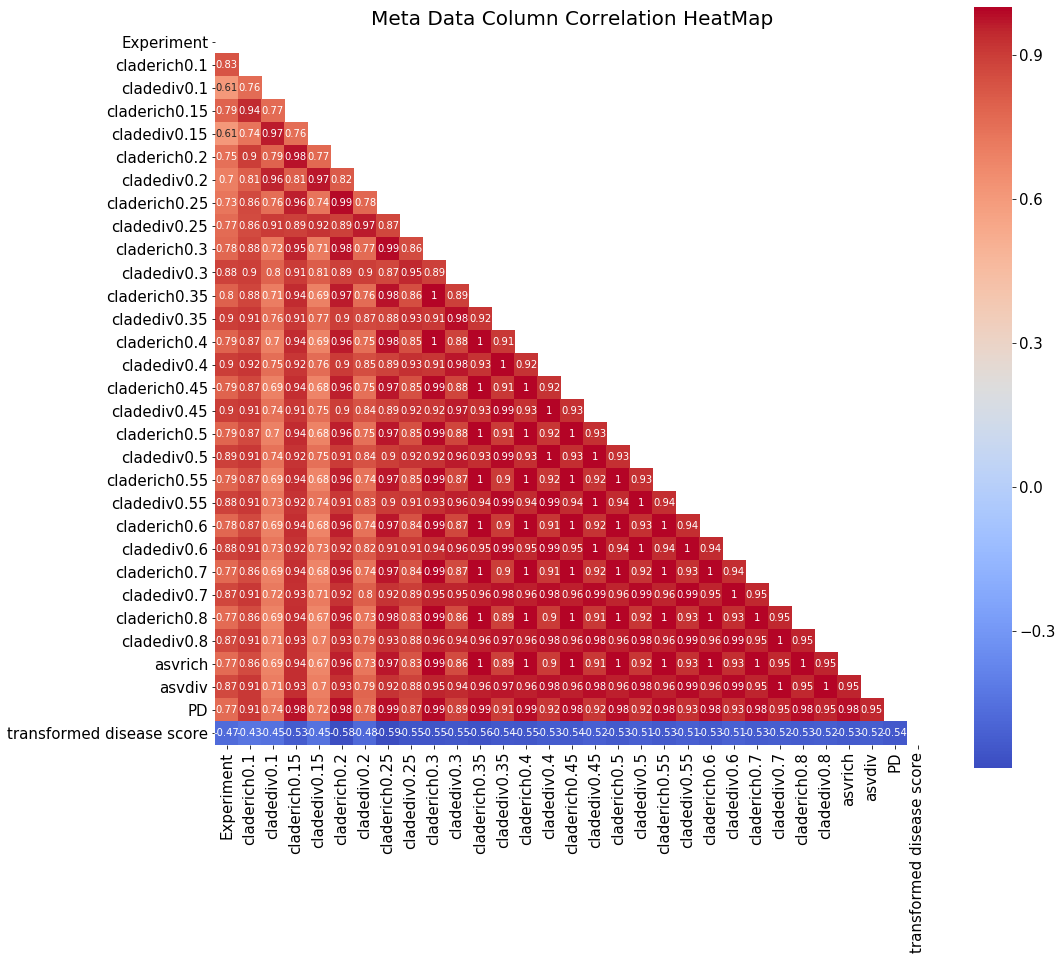

In [24]:
f, ax = plt.subplots(figsize=(16, 14))
Utils.customized_heatmap(meta_and_yt.corr(), ax=ax, annot=True, trim=True, cmap='coolwarm', 
                        title='Meta Data Column Correlation HeatMap', title_size=20, xticklab=meta_and_yt.columns)

From the heatmap, it is clear that the richness of bacteria is negatively related to the plants' susceptibility. The more diverse the bacteria community is, the less vulnerable the potato is. 

In [25]:
def rmse_disease(df, color="black", title="", xlabel="xlabel", ylabel="ylabel"):
    plt.rcParams['figure.figsize'] = (8.0, 4.0)
    s1 = meta.sort_values(by=['seCSscore'], ascending=True)
    s1['mse_CSscore'] = s1.seCSscore
    s1 = s1.set_index('FieldID')
    ax1 = s1['mse_CSscore'].plot.bar(rot=90, color=color)
    ax1.set_title(title, fontsize=20)
    ax1.set_xlabel(xlabel, fontsize=15)
    ax1.set_ylabel(ylabel, fontsize=15)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

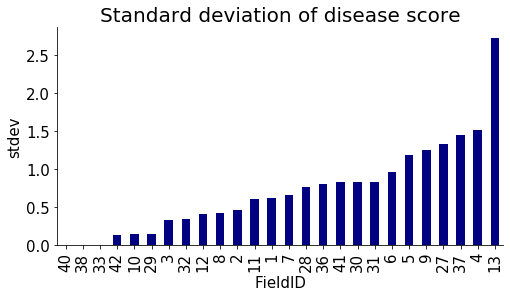

In [26]:
rmse_disease(meta, "navy", title="Standard deviation of disease score", xlabel="FieldID", ylabel="stdev")

# Machine Learning Model

## only meta data


XGBoost Model Report
RMSE for training set: 0.1619955402419921
RMSE for validation set: 0.2829647519463528


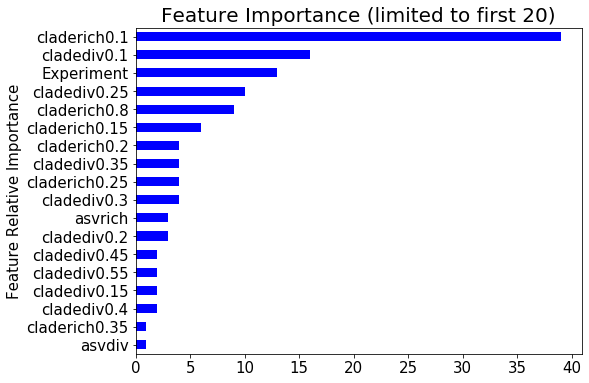

In [21]:
xgb_meta_1 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_pred_meta1, val_pred_meta1, top_meta1 = ml.xgb_fit(xgb_meta_1, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, 
                                          trans_param=trans_param, fs=(8,6))


XGBoost Model Report
RMSE for training set: 0.1619955402419921
RMSE for validation set: 0.2829647519463528


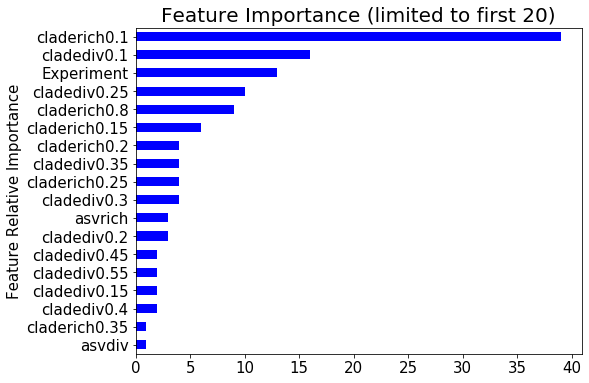

In [22]:
xgb_meta_2 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_pred_meta2, val_pred_meta2, top_meta2 = ml.xgb_fit(xgb_meta_2, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, 
                                          trans_param=trans_param, fs=(8,6))


XGBoost Model Report
RMSE for training set: 0.11447707684580254
RMSE for validation set: 0.28468238332380613


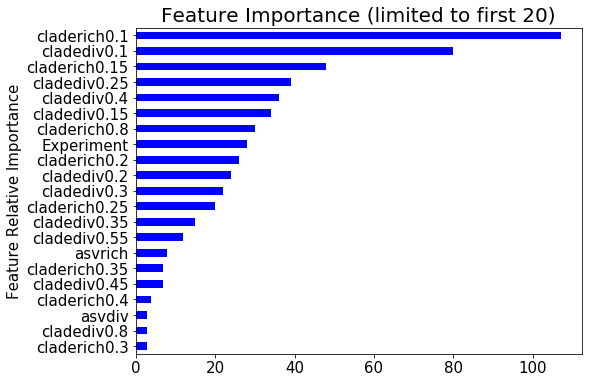

In [29]:
xgb_meta_3 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_pred_meta3, val_pred_meta3, top_meta3 = ml.xgb_fit(xgb_meta_3, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, 
                                          trans_param=trans_param, fs=(8,6))


XGBoost Model Report
RMSE for training set: 0.1445008302627082
RMSE for validation set: 0.27824077113433654


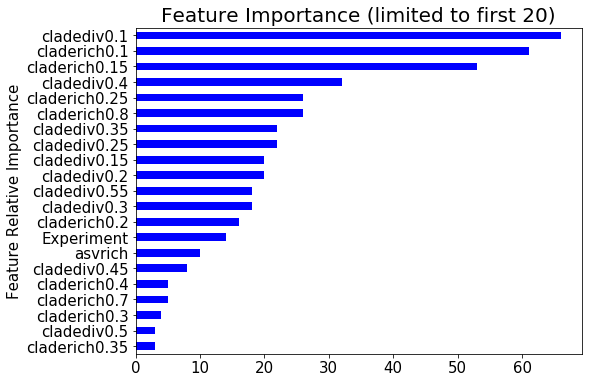

In [30]:
xgb_meta_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=2.5,
    seed=2)
train_pred_meta4, val_pred_meta4, top_meta4 = ml.xgb_fit(xgb_meta_4, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, 
                                          trans_param=trans_param, fs=(8,6))


XGBoost Model Report
RMSE for training set: 0.17021322209689327
RMSE for validation set: 0.28139722689751767


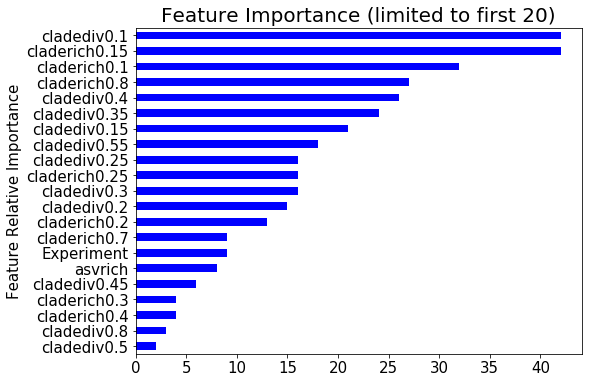

In [31]:
xgb_meta_5 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_pred_meta5, val_pred_meta5, top_meta5 = ml.xgb_fit(xgb_meta_5, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, 
                                          trans_param=trans_param, fs=(8,6))


XGBoost Model Report
RMSE for training set: 0.19110632051742477
RMSE for validation set: 0.2909368467680982


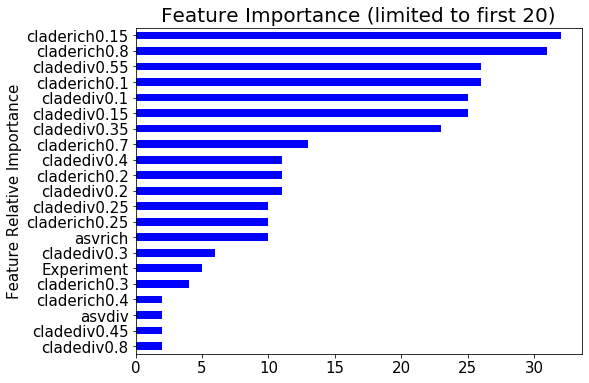

In [32]:
xgb_meta_6 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=10,
    seed=2)
train_pred_meta6, val_pred_meta6, top_meta6 = ml.xgb_fit(xgb_meta_6, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, 
                                          trans_param=trans_param, fs=(8,6))

Using only the meta data, the best comb for XGBoost hyperparameter seems to be  
xgb_meta_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=2.5,
    seed=2)  
    
RMSE for traning set: 0.1445008302627082
RMSE for validation set: 0.27824077113433654


Random Forest Model Report
RMSE for training set: 0.08602709279226231
RMSE for validation set: 0.2399403026489487


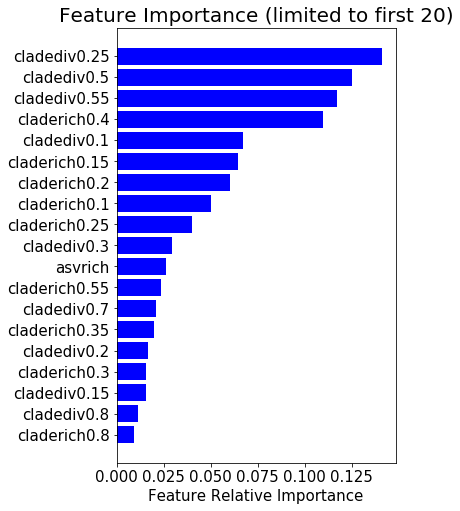

In [23]:
rf_meta_7 = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=2)
train_pred_meta7, val_pred_meta7, top_meta7, rf_meta_7 = \
    ml.rf_fit(rf_meta_7, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, trans_param=trans_param, fs=(5, 8))

This RF model is better than all XGBoost model. 

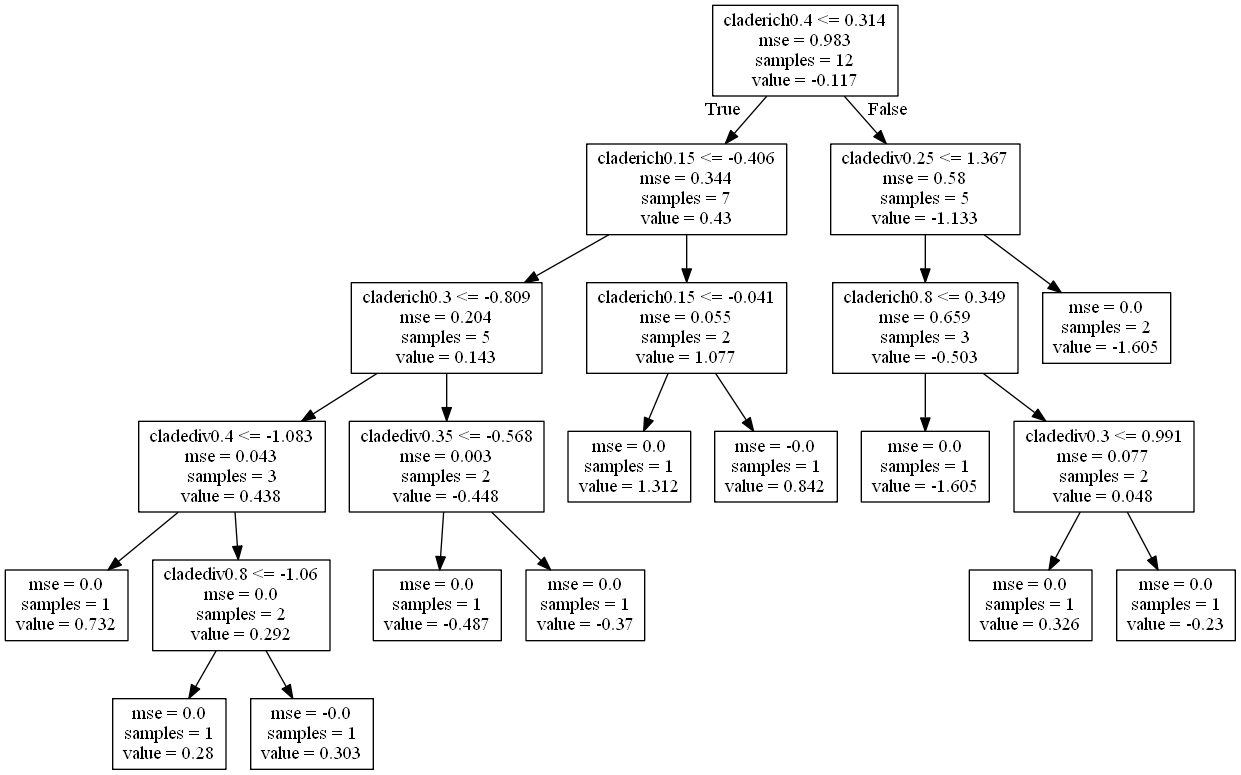

In [26]:
## visualize one of the tree
dot_data = StringIO()
es = rf_meta_7.estimators_[9]
export_graphviz(es, out_file=dot_data, feature_names=xtrain_meta_d.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [35]:
train_pred_rs_meta7, val_pred_rs_meta7, estimators_rs_meta7, param_rs_meta7 = \
    ml.random_search(rf_meta_7, tuning, xtrain_meta_d, ytrain_d, xval_meta_d, yval_d, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.14010987276415698
RMSE for validation set: 0.26859234430625756


In [36]:
param_rs_meta7

{'n_estimators': 70,
 'min_samples_split': 7,
 'max_features': 10,
 'max_depth': 13}

Randomized Search fails to improve its performance. 

## taxa data

# Feature Selection

## LASSO

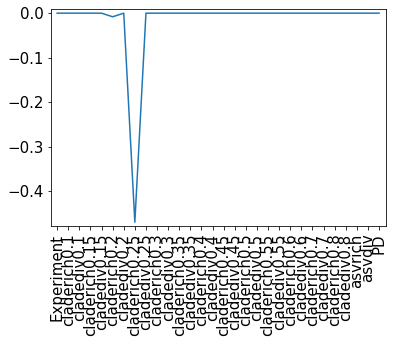

In [29]:
lasso_cv_meta = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=1000).fit(xtrain_meta_d, ytrain_d)
lasso_meta_coef = lasso_cv_meta.coef_
plt.figure(figsize=(6,4))
plt.plot(range(len(xtrain_meta_d.columns)), lasso_meta_coef)
# plt.ylabel('Feature Relative Importance', fontsize=15)
plt.xticks(range(len(xtrain_meta_d.columns)), xtrain_meta_d.columns, rotation=90) 
plt.margins(0.02)
plt.show()
# train_pred_lassocv1 = rmse_cv(lasso_cv)

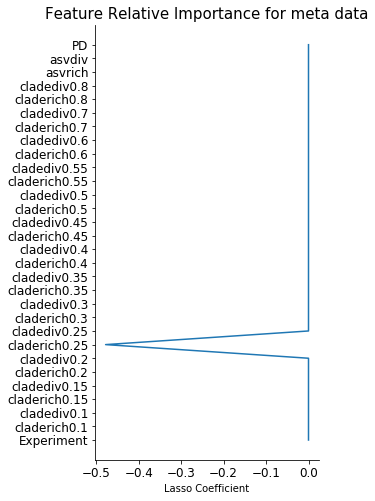

In [42]:
lasso_cv_meta = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=1000).fit(xtrain_meta_d, ytrain_d)
lasso_meta_coef = lasso_cv_meta.coef_
fig, ax = plt.subplots(figsize=(4, 8))
ax.plot(lasso_meta_coef, xtrain_meta_d.columns)
ax.set_title('Feature Relative Importance for meta data', fontsize=15)
ax.set_xlabel('Lasso Coefficient')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [52]:
## without change this to DataFrame, the result will be a pd.Series, which change the size of it
xtrain_meta_lasso_d, xval_meta_lasso_d = pd.DataFrame(xtrain_meta_d['claderich0.25']), pd.DataFrame(xval_meta_d['claderich0.25'])
xtrain_meta_lasso_d.head(2)

,claderich0.25
FieldID,
33,-0.008407
36,0.592663


In [53]:
ridge_meta_lasso1 = Ridge(alpha=2, copy_X=True, solver='lsqr', random_state=2)
ridge_meta_lasso_coef1, ridge_meta_lasso_intercept1 = \
ml.ridge_fit(ridge_meta_lasso1, xtrain_meta_lasso_d, ytrain_d, xval_meta_lasso_d, yval_d, trans_param=trans_param, fs=(4, 4))


Ridge Regression Model Report
RMSE for training set: 0.1830947924582035
RMSE for validation set: 0.25526404070441655


In [54]:
ridge_meta_lasso2 = Ridge(alpha=0.5, copy_X=True, solver='lsqr', random_state=2)
ridge_meta_lasso_coef2, ridge_meta_lasso_intercept2 = \
ml.ridge_fit(ridge_meta_lasso2, xtrain_meta_lasso_d, ytrain_d, xval_meta_lasso_d, yval_d, trans_param=trans_param, fs=(4, 4))


Ridge Regression Model Report
RMSE for training set: 0.18260337541024577
RMSE for validation set: 0.25457901975785463


In [55]:
ridge_meta_lasso_coef2, ridge_meta_lasso_intercept2

(array([-0.57154194]), -0.01466600533704987)

This is the best we can get so far!!

In [56]:
ridge_grid1  = {'alpha':np.linspace(0.2,8,20)}
_, _, ridge_meta_lasso_grid_est, ridge_meta_lasso_grid_param = \
ml.grid_search(ridge_meta_lasso2, ridge_grid1, xtrain_meta_lasso_d, ytrain_d, xval_meta_lasso_d, yval_d, trans_param=trans_param, cv=4)


Grid Search Tuning Report
RMSE for traning set: 0.18367973314705194
RMSE for validation set: 0.2559470317885557


In [57]:
ridge_meta_lasso_grid_param

{'alpha': 3.073684210526316}

Grid Search for Ridge Regression does not improve the performance. 


Random Forest Model Report
RMSE for training set: 0.11629595822532678
RMSE for validation set: 0.24824146048390744


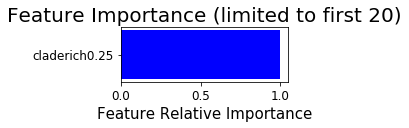

In [82]:
rf_meta_lasso1 = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=2, max_depth=4)
train_pred_meta_lasso1, val_pred_meta_lasso1, _, rf_meta_lasso1 = \
    ml.rf_fit(rf_meta_lasso1, xtrain_meta_lasso_d, ytrain_d, xval_meta_lasso_d, yval_d, trans_param=trans_param, fs=(3, 1))

In [59]:
xtrain_meta_lasso_d.shape

(20, 1)

In [69]:
pd.concat([xtrain_meta_lasso_d, ytrain_d], axis=1)

,claderich0.25,diffCSscore
FieldID,,
33,-0.008407,-1.605319
36,0.592663,-0.230164
5,-0.838975,0.814400
3,-0.489262,-0.154928
37,0.188307,0.842071
7,-1.057546,0.744778
28,-0.489262,0.093800
8,-0.675047,-0.369501
40,1.412303,-1.605319


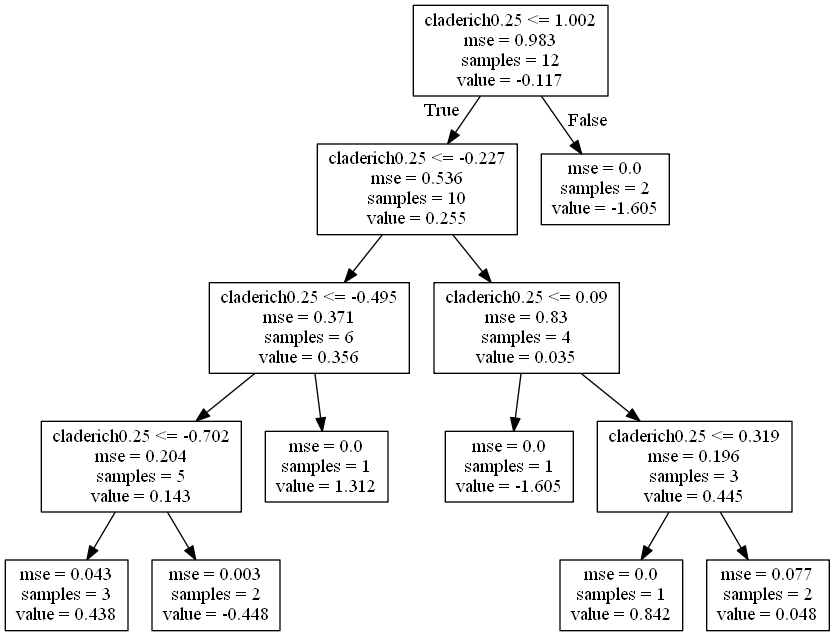

In [79]:
## visualize one of the tree
dot_data = StringIO()
es = rf_meta_lasso1.estimators_[9]
export_graphviz(es, out_file=dot_data, feature_names=xtrain_meta_lasso_d.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [46]:
# Using only part of taxa data instead, selecting using full part of taxa data is time consuming
taxa_xgb_4 = top_taxa4.index[:20]
xtrain_taxa_xgb_d, xval_meta_xgb_d = xtrain_taxa_d[taxa_xgb_4], xval_taxa_d[taxa_xgb_4]

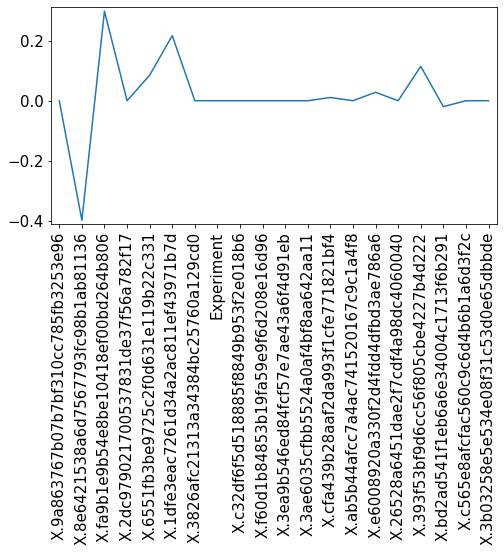

In [71]:
lasso_cv_taxa = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=1000).fit(xtrain_taxa_xgb_d, ytrain_d)
lasso_taxa_coef = lasso_cv_taxa.coef_
plt.plot(range(len(xtrain_taxa_xgb_d.columns)), lasso_taxa_coef)
plt.xticks(range(len(xtrain_taxa_xgb_d.columns)), xtrain_taxa_xgb_d.columns, rotation=90) 
plt.margins(0.02)
plt.show()

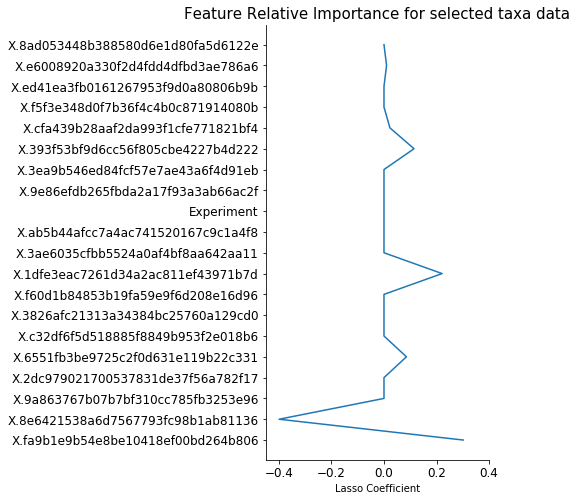

In [50]:
lasso_cv_taxa = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=1000).fit(xtrain_taxa_xgb_d, ytrain_d)
lasso_taxa_coef = lasso_cv_taxa.coef_
fig, ax = plt.subplots(figsize=(4, 8))
ax.plot(lasso_taxa_coef, xtrain_taxa_xgb_d.columns)
ax.set_xlim(-0.45, 0.4)
ax.set_title('Feature Relative Importance for selected taxa data', fontsize=15)
ax.set_xlabel('Lasso Coefficient')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [72]:
lasso_cv_taxa.coef_

array([ 0.        , -0.39791628,  0.29820104,  0.        ,  0.08501479,
        0.21662034,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.01080692,  0.        ,  0.02814434,
        0.        ,  0.1144813 , -0.01961881, -0.        ,  0.        ])

In [73]:
tmp = taxa_xgb_4[lasso_cv_taxa.coef_!=0]
tmp

Index(['X.8e6421538a6d7567793fc98b1ab81136',
       'X.fa9b1e9b54e8be10418ef00bd264b806',
       'X.6551fb3be9725c2f0d631e119b22c331',
       'X.1dfe3eac7261d34a2ac811ef43971b7d',
       'X.cfa439b28aaf2da993f1cfe771821bf4',
       'X.e6008920a330f2d4fdd4dfbd3ae786a6',
       'X.393f53bf9d6cc56f805cbe4227b4d222',
       'X.bd2ad541f1eb6a6e34004c1713f6b291'],
      dtype='object')

In [74]:
xtrain_taxa_lasso_d, xval_taxa_lasso_d = xtrain_taxa_d[tmp], xval_taxa_d[tmp]

In [75]:
ridge_taxa_lasso1 = Ridge(alpha=2, copy_X=True, solver='lsqr', random_state=2)
ridge_taxa_lasso_coef1, ridge_taxa_lasso_intercept1 = \
    ml.ridge_fit(ridge_taxa_lasso1, xtrain_taxa_lasso_d, ytrain_d, xval_taxa_lasso_d, yval_d, trans_param=trans_param, fs=(4, 4))


Ridge Regression Model Report
RMSE for training set: 0.06708639340462352
RMSE for validation set: 0.3333399338003537


Using these 8 bacterial communities can acheive similar result as full taxa data.

In [76]:
ridge_grid1  = {'alpha':np.linspace(0.2,8,20)}
_, _, ridge_taxa_lasso_grid_est, ridge_taxa_lasso_grid_param = \
    ml.grid_search(ridge_taxa_lasso1, ridge_grid1, xtrain_taxa_lasso_d, ytrain_d, xval_taxa_lasso_d, yval_d, trans_param=trans_param, cv=4)


Grid Search Tuning Report
RMSE for traning set: 0.06739453978489474
RMSE for validation set: 0.3327595889683362


In [77]:
ridge_taxa_lasso_grid_est

Ridge(alpha=2.2526315789473688, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=2, solver='lsqr',
   tol=0.001)


XGBoost Model Report
RMSE for training set: 0.12250147195852061
RMSE for validation set: 0.325405677296035


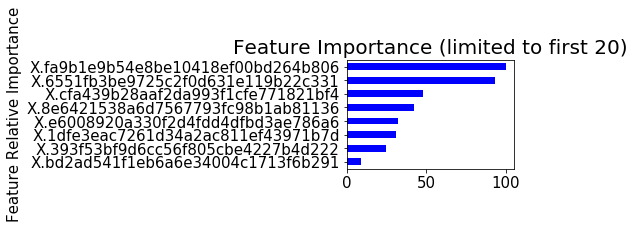

In [78]:
xgb_taxa_lasso1 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=60,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_pred_taxa_lasso1, val_pred_taxa_lasso1, _ = \
    ml.xgb_fit(xgb_taxa_lasso1, xtrain_taxa_lasso_d, ytrain_d, xval_taxa_lasso_d, yval_d, trans_param=trans_param, fs=(3,2))

XGBoost improves a little, not too much. 


Random Forest Model Report
RMSE for training set: 0.058293587475333884
RMSE for validation set: 0.3451409708503952


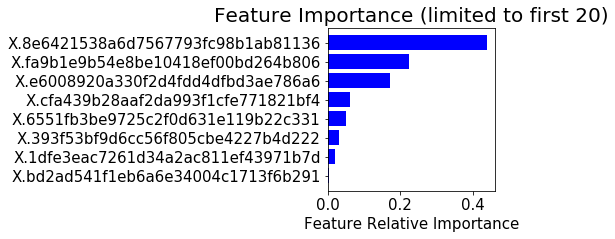

In [79]:
rf_taxa_lasso1 = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=2)
train_pred_taxa_lasso1, val_pred_taxa_lasso1, _, rf_taxa_lasso1 = \
    ml.rf_fit(rf_taxa_lasso1, xtrain_taxa_lasso_d, ytrain_d, xval_taxa_lasso_d, yval_d, trans_param=trans_param, fs=(3, 3))

# Conclusion

In [81]:
md_coef, md_intercept = ridge_meta_lasso_coef2[0], ridge_meta_lasso_intercept2
md_coef, md_intercept = np.round(md_coef, 5), np.round(md_intercept, 5)
md_coef, md_intercept

(-0.57154, -0.01467)

## constructing y

In [85]:
yt

FieldID
1     0.015142
2    -0.486763
3    -0.154928
4     1.195968
5     0.814400
6     0.303205
7     0.744778
8    -0.369501
9     1.312314
10    0.732274
11   -0.339759
12    0.279803
13    2.075431
27    1.424344
28    0.093800
29    0.326124
30   -0.409760
31   -0.252561
32   -1.605319
33   -1.605319
36   -0.230164
37    0.842071
38   -1.605319
40   -1.605319
41    0.142125
42   -1.605319
Name: diffCSscore, dtype: float64

In [132]:
y = meta.diffCSscore
y.index = meta_clean_2.index  
y

FieldID
1     1.280556
2     0.762103
3     1.089286
4     3.208333
5     2.450000
6     1.646429
7     2.327381
8     0.871230
9     3.471667
10    2.305833
11    0.900000
12    1.614583
13    5.665179
27    3.741000
28    1.375000
29    1.678000
30    0.833000
31    0.987000
32    0.000000
33    0.000000
36    1.010000
37    2.500000
38    0.000000
40    0.000000
41    1.435000
42    0.000000
Name: diffCSscore, dtype: float64

## constructing x

In [90]:
x_rich25 = total['claderich0.25']
x_rich25

FieldID
1    -0.379977
2    -0.543905
3    -0.489262
4    -0.784333
5    -0.838975
6    -0.729690
7    -1.057546
8    -0.675047
9    -0.445548
10   -0.904546
11   -0.817118
12   -1.024760
13   -0.653190
27    0.789376
28   -0.489262
29    0.450592
30   -0.379977
31    0.811234
32    1.663659
33   -0.008407
36    0.592663
37    0.188307
38    0.975162
40    1.412303
41    0.221093
42    3.117154
Name: claderich0.25, dtype: float64

In [137]:
# acquire the untransformed x
print(mu_total['claderich0.25'], sd_total['claderich0.25'])
x_rich25_unnormalized = x_rich25*sd_total['claderich0.25']+mu_total['claderich0.25']
x_rich25_unnormalized

(152.76923076923077, 91.50357706332915)

## constructing model for unnormalized parameters

In [145]:
unnormalized_coef = md_coef/sd_total['claderich0.25']
unnormalized_intercpt = md_intercept - md_coef*mu_total['claderich0.25']/sd_total['claderich0.25']
unnormalized_coef, unnormalized_intercpt

(-0.006246094615562845, 0.9395410697313701)

In [175]:
def linear(linex, coef, intercpt):
    liney = coef*linex + intercpt
    if intercpt < 0:
        lb = 'y=%.3fx-%.3f'% (coef, -intercpt)
    else:
        lb = 'y=%.3fx+%.3f'% (coef, intercpt)
    return liney, lb

In [192]:
def untransformed(line_x, coef, intercpt):
    line_y = coef*line_x + intercpt
    line_y = Utils.johnson_inverse(line_y, gamma, eta, epsilon, lbda)
    b_ = intercpt - gamma
    if b_ > 0:
        lb = r'y=$%.3f*\sinh(\frac{%.3fx+%.3f}{%.3f})-%.3f$'% (lbda, coef, b_, eta, -epsilon)
    else:
        lb = r'y=$%.3f*\sinh(\frac{%.3fx-%.3f}{%.3f})-%.3f$'% (lbda, coef, -b_, eta, -epsilon)
    return line_y, lb

In [188]:
def model_visualization(ax, coef, intercpt, x, y, transformed, title='', xlab='x', ylab='y', title_font=15, lab_font=15):
    line_x = np.linspace(min(x), max(x), 100)
    if transformed:
        line_y, lb = linear(line_x, coef, intercpt)
    else:
        line_y, lb = untransformed(line_x, coef, intercpt)
    ax.plot(line_x, line_y, '-m', label=lb)
    ax.scatter(x, y)
    ax.set_xlim(min(min(x) - 0.4, 0))
    ax.set_title(title, fontsize=title_font)
    ax.set_xlabel(xlab, fontsize=lab_font, color='#1C2833')
    ax.set_ylabel(ylab, fontsize=lab_font, color='#1C2833')
    ax.legend(loc='upper right')
    ax.grid()

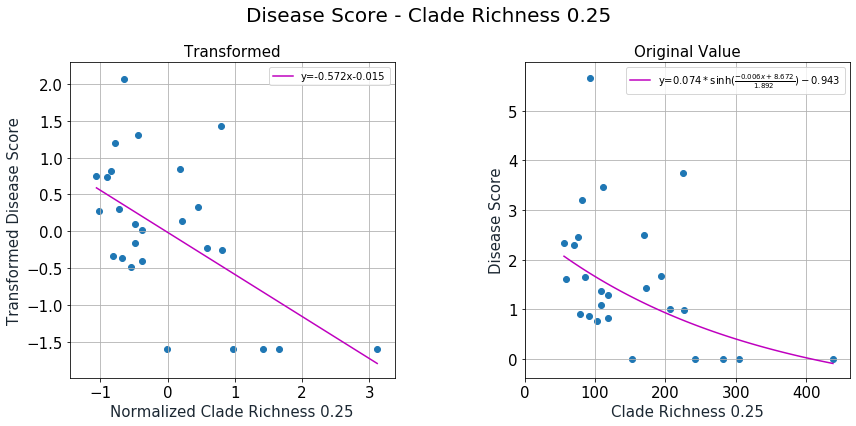

In [193]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Disease Score - Clade Richness 0.25", fontsize=20)
ax1 = fig.add_subplot(1,2,1)
model_visualization(ax1, md_coef, md_intercept, x_rich25, yt, transformed=True, title='Transformed', 
                    xlab='Normalized Clade Richness 0.25', ylab='Transformed Disease Score')
ax2 = fig.add_subplot(1,2,2)
model_visualization(ax2, unnormalized_coef, unnormalized_intercpt, x_rich25_unnormalized, y, transformed=False, 
                     title='Original Value', xlab='Clade Richness 0.25', ylab='Disease Score')
fig.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.4, hspace=0.15)

The recommend way is to do it in the transformed way. Expected error is 0.25 in the unit of transformed disease score. 